In [1]:
!wget "https://storage.googleapis.com/laubenthal_spatiolab/spatio_merged_data_iss.zip" --no-verbose
!unzip spatio_merged_data_iss.zip
!rm spatio_merged_data_iss.zip

2021-01-17 14:17:41 URL:https://storage.googleapis.com/laubenthal_spatiolab/spatio_merged_data_iss.zip [37039712/37039712] -> "spatio_merged_data_iss.zip" [1]
Archive:  spatio_merged_data_iss.zip
   creating: input/
  inflating: input/.DS_Store         
  inflating: __MACOSX/input/._.DS_Store  
  inflating: input/grid_ML.geojson   
  inflating: __MACOSX/input/._grid_ML.geojson  
  inflating: input/satelite.png      
  inflating: __MACOSX/input/._satelite.png  
  inflating: input/weather.csv       
  inflating: __MACOSX/input/._weather.csv  
  inflating: input/social_pulse_ML.csv  
  inflating: __MACOSX/input/._social_pulse_ML.csv  
  inflating: input/f_internet_ML.csv  
  inflating: __MACOSX/input/._f_internet_ML.csv  


In [2]:
!rm -rf functions
!git clone https://github.com/markuslaubenthal/lab_st.git functions

Cloning into 'functions'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 38 (delta 6), reused 33 (delta 4), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, activations
from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf

In [2]:
internet_origin = pd.read_csv('input/f_internet_ML.csv' , index_col='index')
internet_origin = internet_origin.to_numpy()
internet = np.log10(internet_origin + 1)
internet_max = internet.max(axis=1)
internet_min = internet.min(axis=1)
internet = (internet - internet_min[:,np.newaxis]) / (internet_max - internet_min)[:,np.newaxis]
internet = internet.T.reshape((1488,100,100))
satelite = cv2.imread('input/satelite.png')
satelite = (satelite - satelite.min()) / (satelite.max() - satelite.min())
satelite = np.flip(satelite, axis=0)
social = pd.read_csv('input/social_pulse_ML.csv', index_col=0)
social = social.to_numpy()
social = (social - social.min(axis=1)[:,np.newaxis]) / (social.max(axis=1) - social.min(axis=1) + 1)[:,np.newaxis]
social = social.T.reshape((1488,100,100))
weather = pd.read_csv('input/weather.csv', index_col=0)
weather = weather.to_numpy()
weather = (weather - weather.min(axis=1)[:,np.newaxis]) / (weather.max(axis=1) - weather.min(axis=1) + 1)[:,np.newaxis]
weather = weather.T.reshape((1488,100,100))
hour = np.zeros((1488,24))
weekday = np.zeros((1488,7))
holiday = np.zeros((1488))
for i in range(1488):
  hour[i, i % 24] = 1
  day = i // 24
  weekday[i,day % 7] = 1
  if day % 7 in [1,2]:
    holiday[i] = 1
  elif day in [0,54,56,61,62]:
    holiday[i] = 1

In [3]:
from threading import Thread
#!pip install statsmodels==0.12.1
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
statsmodels.__version__
# should return 0.12.1

'0.12.1'

In [4]:
def paralleli(t,_y,_x):
  global pred
  global internet
  start = max(t-168*2,0)
  fit = ExponentialSmoothing(internet[start:t,_y,_x] + 1, 
                                  seasonal_periods=24, 
                                  trend='add', 
                                  seasonal='add', 
                                  use_boxcox=True, 
                                  initialization_method="estimated").fit()
  pred[t,_y,_x] = fit.fcastvalues - 1

In [ ]:
pred = np.zeros(internet.shape)
for _y in range(100):
  for _x in range(100):
    threads = list()
    for t in range(168, internet.shape[0]):
        x = Thread(target=paralleli, args=(t,_y,_x))
        threads.append(x)
        x.start()
    for index, thread in enumerate(threads):
      thread.join()
    print(_y,_x)

In [8]:
pred = pred[168:]

In [11]:
# takes prediction pred for the entire sequence
pred = pred.reshape((pred.shape[0],10000)).T
pred = pred * (internet_max - internet_min)[:,np.newaxis] + internet_min[:,np.newaxis]
pred = np.power(np.full(pred.shape, 10), pred)
base = internet_origin[:,168:]
print('all: ', np.sqrt(((pred-base)**2).mean()))
print('test: ', np.sqrt(((pred[:,:-168]-base[:,:-168])**2).mean()))
print('val: ', np.sqrt(((pred[:,-168:]-base[:,-168:])**2).mean()))

all:  689.225468175742
test:  727.6670561194968
val:  318.6528541165537


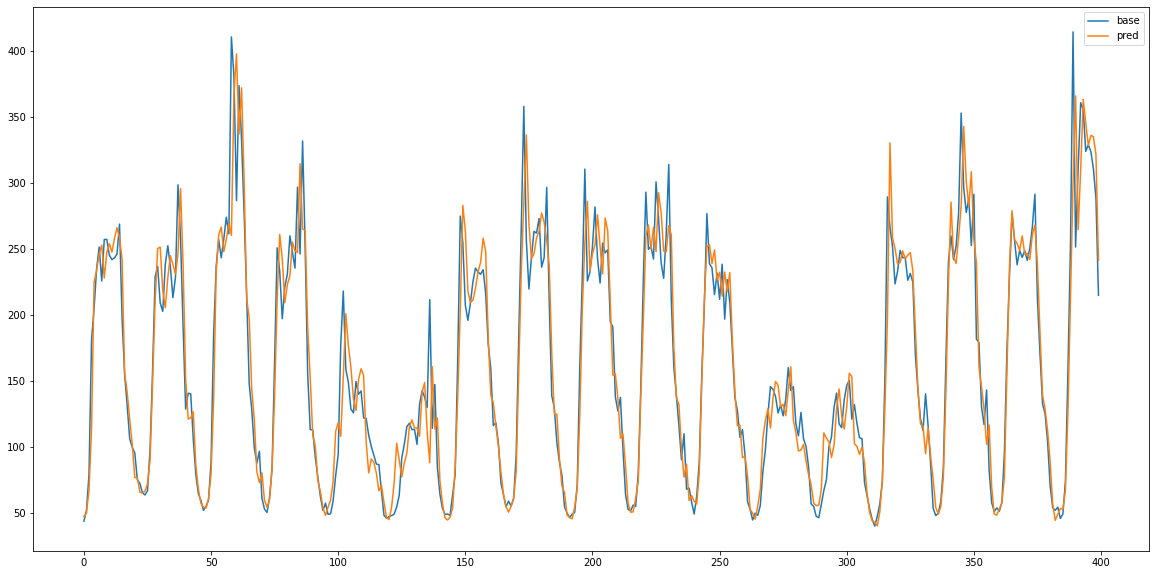

In [12]:
# reference plot
plt.figure(figsize=(20,10))
plt.plot(range(400), base[2878,100:500], label='base')
plt.plot(range(400), pred[2878,100:500], label='pred')
plt.legend()